# Tutorial: SP1 bindings in Cre-driver mouse lines. 

 The data is from [Cammack et al., PNAS. (2020)](https://www.pnas.org/doi/10.1073/pnas.1918241117).

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc



Read bulk calling cards ccf data for both P10 and P28 cohort. The columns indecate the chromosome, the start, end point of each htop, read number, direction and cell barcodes. Give them another column to distinguish. 

In [2]:
SP1_P10 = cc.datasets.SP1_Cre_data(data="SP1_P10")
SP1_P10['sample'] = 'P10'
SP1_P10

,Chr,Start,End,Reads,Direction,Barcodes,sample
0,chr1,3095378,3095382,7,+,TAAGG,P10
1,chr1,3120128,3120132,1,+,GTTAC,P10
2,chr1,3121275,3121279,10,-,GTTAC,P10
3,chr1,3121275,3121279,2,-,GTTAC,P10
4,chr1,3222947,3222951,1,-,GTTAC,P10
...,...,...,...,...,...,...,...
271941,chrY,1010004,1010008,1,-,GTTAC,P10
271942,chrY,1011155,1011159,12,-,GTTAC,P10
271943,chrY,1178766,1178770,10,+,GTTAC,P10
271944,chrY,1244787,1244791,11,+,GTTAC,P10


In [3]:
SP1_P28 = cc.datasets.SP1_Cre_data(data="SP1_P28")
SP1_P28['sample'] = 'P28'
SP1_P28

,Chr,Start,End,Reads,Direction,Barcodes,sample
0,chr1,3071865,3071869,76,+,GTCAT,P28
1,chr1,3095378,3095382,7,+,ACTGC,P28
2,chr1,3102707,3102711,1,-,GTCAT,P28
3,chr1,3119905,3119909,4,+,GTCAT,P28
4,chr1,3120189,3120193,66,-,GTCAT,P28
...,...,...,...,...,...,...,...
1083094,chrY,90803579,90803583,14,-,GTCAT,P28
1083095,chrY,90805130,90805134,10,+,ACTGC,P28
1083096,chrY,90805130,90805134,1,+,CGAAA,P28
1083097,chrY,90806531,90806535,5,-,GTCAT,P28


In order to call peak together, we need to conbine two ccf files together.

In [4]:
SP1 = cc.rd.combine_ccf([SP1_P10,SP1_P28])
SP1

,Chr,Start,End,Reads,Direction,Barcodes,sample
0,chr1,3071865,3071869,76,+,GTCAT,P28
1,chr1,3095378,3095382,7,+,TAAGG,P10
2,chr1,3095378,3095382,7,+,ACTGC,P28
3,chr1,3102707,3102711,1,-,GTCAT,P28
4,chr1,3119905,3119909,4,+,GTCAT,P28
...,...,...,...,...,...,...,...
1355040,chrY,90803579,90803583,14,-,GTCAT,P28
1355041,chrY,90805130,90805134,10,+,ACTGC,P28
1355042,chrY,90805130,90805134,1,+,CGAAA,P28
1355043,chrY,90806531,90806535,5,-,GTCAT,P28


We then read the background file.

In [5]:
bg = cc.datasets.SP1_Cre_data(data="background")
bg

,Chr,Start,End,Reads,Direction,Barcodes
0,chr1,3004272,3004276,5,+,ACTGC
1,chr1,3028063,3028067,6,-,ACTGC
2,chr1,3043241,3043245,1,-,ACTGC
3,chr1,3049117,3049121,1,-,CAGTG
4,chr1,3052152,3052156,1,+,ACTGC
...,...,...,...,...,...,...
5573105,chrY,90811001,90811005,2,+,CAGTG
5573106,chrY,90811001,90811005,1,+,CAGTG
5573107,chrY,90811001,90811005,1,+,CAGTG
5573108,chrY,90811001,90811005,2,+,TGACA


We now call the peaks under the backgroud to diagnose potential binding sites.

In [6]:
peak_data = cc.pp.callpeaks(SP1, bg,  method = "test", reference = "mm10", pvalue_cutoffbg = 0.1, maxbetween = 1800,
                  pvalue_cutoffTTAA = 0.001, lam_win_size = None,  pseudocounts = 0.1, record = True, save = "peak.bed")
peak_data

For the test method with background, [expdata, background, reference, pvalue_cutoffbg, pvalue_cutoffTTAA, lam_win_size, pseudocounts, minlen, extend, maxbetween, test_method, min_hops, record] would be utilized.


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


,Chr,Start,End,Experiment Hops,Background Hops,Reference Hops,Expected Hops background,Expected Hops Reference,pvalue Background,pvalue Reference
0,chr1,3119705,3121479,5,11,12,2.662780,1.019967,3.871438e-02,6.578874e-04
1,chr1,3492726,3493906,6,14,9,2.022085,0.789975,3.824654e-02,1.915941e-05
2,chr1,3672013,3673194,61,47,9,2.022085,0.789975,0.000000e+00,0.000000e+00
3,chr1,4773450,4774237,6,5,4,0.954260,0.406656,2.134275e-04,2.559005e-07
4,chr1,4785206,4786670,31,47,13,2.876345,1.096631,3.342206e-08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
23573,chrY,896958,898518,6,4,12,3.114493,0.102376,1.528281e-04,2.138312e-11
23574,chrY,1009804,1011443,17,2,16,4.119324,0.103168,0.000000e+00,0.000000e+00
23575,chrY,1244073,1246463,6,9,21,5.375362,0.104157,1.067924e-02,2.409062e-11
23576,chrY,1286004,1286939,6,5,11,2.863285,0.102178,5.168551e-04,2.109901e-11


The above approach is first combine the data and then call peaks together. Although not recommended, you could also try call peaks seperately and then merge the peaks by [pybedtools](https://daler.github.io/pybedtools/). Below are the codes:

```python
import pybedtools
peak_data1 = cc.pp.callpeaks(SP1_P10, bg,  method = "test", reference = "mm10", pvalue_cutoffbg = 0.1, maxbetween = 1800,
                  pvalue_cutoffTTAA = 0.001, lam_win_size = None,  pseudocounts = 0.1, record = True)
peak_data2 = cc.pp.callpeaks(SP1_P28, bg,  method = "test", reference = "mm10", pvalue_cutoffbg = 0.1, maxbetween = 1800,
                  pvalue_cutoffTTAA = 0.001, lam_win_size = None,  pseudocounts = 0.1, record = True)
peak = cc.rd.combine_ccf([peak_data1,peak_data2])
peak = pybedtools.BedTool.from_dataframe(peak).merge().to_dataframe() 
peak_data = peak.rename(columns={"chrom":"Chr", "start":"Start", "end":"End"})

```


In order to choose good paramenters/method for peak calling. Taking a look at the genome is strongly adviced.

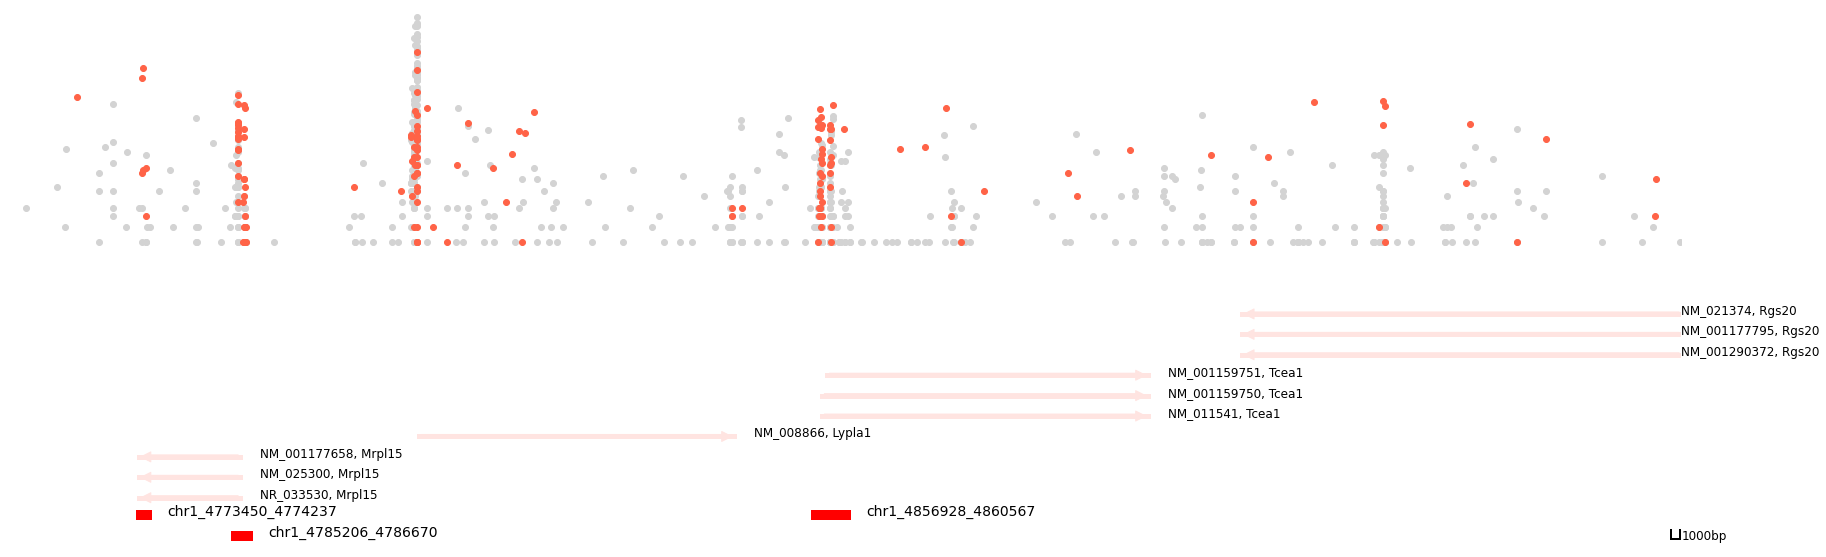

In [7]:
cc.pl.draw_area("chr1",4856929,4863861,100000,peak_data, SP1, "mm10", bg,
                figsize = (30,10),peak_line = 2,save = False, example_length = 1000)

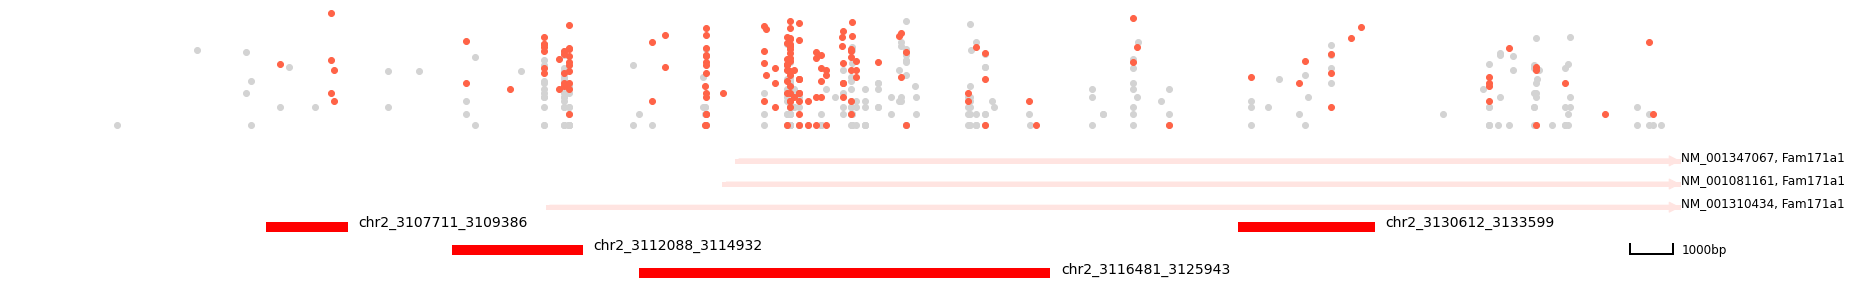

In [8]:
cc.pl.draw_area("chr2",3116481,3125943,15000,peak_data, SP1, "mm10", bg,
                figsize = (30,5),peak_line = 3,save = False, example_length = 1000)

Find out the closest genes for each peak to annotate.

In [9]:
peak_annotation = cc.pp.annotation(peak_data, reference = "mm10")
peak_annotation = cc.pp.combine_annotation(peak_data,peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


,Chr,Start,End,Experiment Hops,Background Hops,Reference Hops,Expected Hops background,Expected Hops Reference,pvalue Background,pvalue Reference,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
0,chr1,3119705,3121479,5,11,12,2.662780,1.019967,3.871438e-02,6.578874e-04,NM_001011874,Xkr4,NM_001195662,Rp1
1,chr1,3492726,3493906,6,14,9,2.022085,0.789975,3.824654e-02,1.915941e-05,NM_001011874,Xkr4,NM_001195662,Rp1
2,chr1,3672013,3673194,61,47,9,2.022085,0.789975,0.000000e+00,0.000000e+00,NM_001011874,Xkr4,NM_001195662,Rp1
3,chr1,4773450,4774237,6,5,4,0.954260,0.406656,2.134275e-04,2.559005e-07,NR_033530,Mrpl15,NM_008866,Lypla1
4,chr1,4785206,4786670,31,47,13,2.876345,1.096631,3.342206e-08,0.000000e+00,NR_033530,Mrpl15,NM_008866,Lypla1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23573,chrY,896958,898518,6,4,12,3.114493,0.102376,1.528281e-04,2.138312e-11,NM_011419,Kdm5d,NM_011667,Uba1y
23574,chrY,1009804,1011443,17,2,16,4.119324,0.103168,0.000000e+00,0.000000e+00,NM_012011,Eif2s3y,NR_027507,Tspy-ps
23575,chrY,1244073,1246463,6,9,21,5.375362,0.104157,1.067924e-02,2.409062e-11,NM_009484,Uty,NM_012008,Ddx3y
23576,chrY,1286004,1286939,6,5,11,2.863285,0.102178,5.168551e-04,2.109901e-11,NM_012008,Ddx3y,NM_148943,Usp9y


Use ccf data, peak data and barcodes data to make a sample by peak anndata object.

In [10]:
adata_ccf = cc.pp.makeAnndata(SP1, peak_annotation, ["P10", "P28"], key = 'sample')
adata_ccf

AnnData object with n_obs × n_vars = 2 × 23578
    var: 'Chr', 'Start', 'End', 'Experiment Hops', 'Background Hops', 'Reference Hops', 'Expected Hops background', 'Expected Hops Reference', 'pvalue Background', 'pvalue Reference', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

Although one peak should have many htops, but there is a chance that all the cells from the peak was filtered by the RNA preprocesssing. In this case, we advice to filter the peaks. 

In [11]:
cc.pp.filter_peaks(adata_ccf, min_counts=5)
adata_ccf

AnnData object with n_obs × n_vars = 2 × 23578
    var: 'Chr', 'Start', 'End', 'Experiment Hops', 'Background Hops', 'Reference Hops', 'Expected Hops background', 'Expected Hops Reference', 'pvalue Background', 'pvalue Reference', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2', 'n_counts'

Differential binding analysis would find out the significant binding for each cluster.

In [12]:
cc.tl.rank_peak_groups(adata_ccf,"Index",method = 'fisher_exact',key_added = 'fisher_exact')

Plot the results for differential binding analysis.

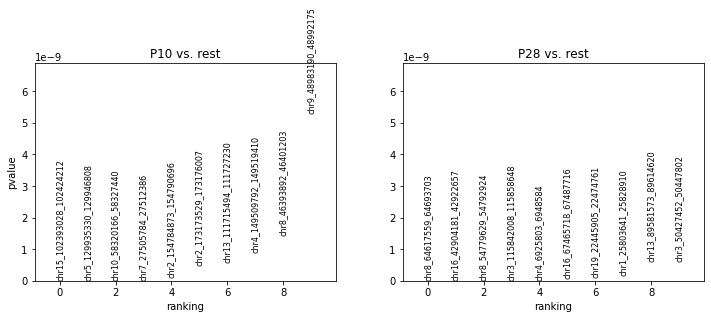

In [13]:
cc.pl.rank_peak_groups(adata_ccf, key = 'fisher_exact')

Take a look at the genome for highly differentiated peaks is strongly adviced.

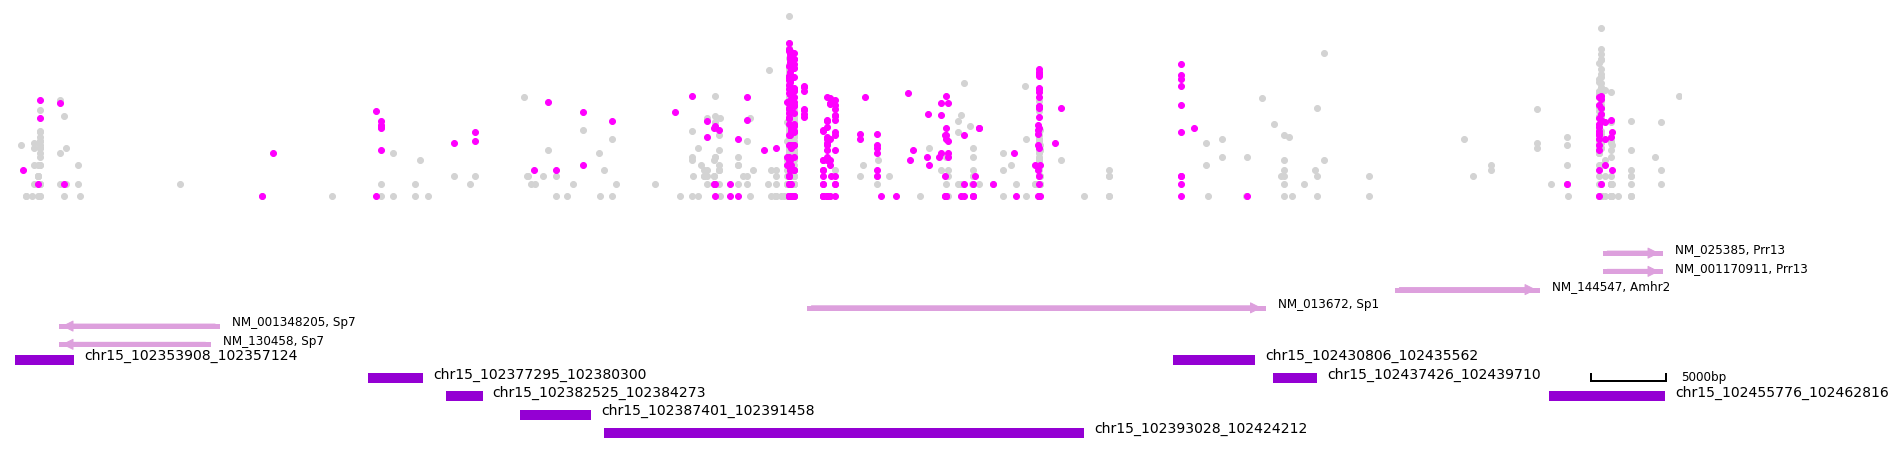

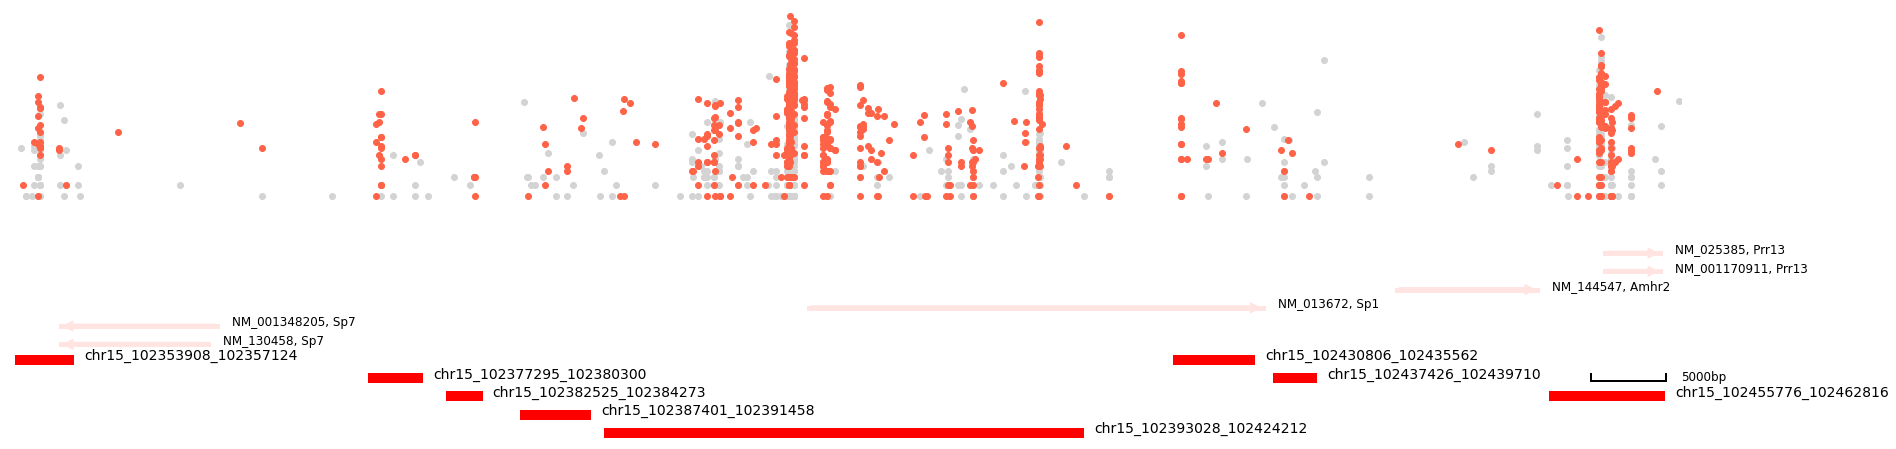

In [14]:
cc.pl.draw_area("chr15",102393028,102424212,40000, peak_data, SP1,"mm10",adata = adata_ccf, background = bg,
                name = "P10",key = "Index",htopkey = "sample", figsize = (30,8),peak_line = 5,example_length=5000,color = "purple")
cc.pl.draw_area("chr15",102393028,102424212,40000, peak_data, SP1,"mm10",adata = adata_ccf, background = bg,
                name = "P28",key = "Index", htopkey = "sample", figsize = (30,8),peak_line = 5,example_length=5000)

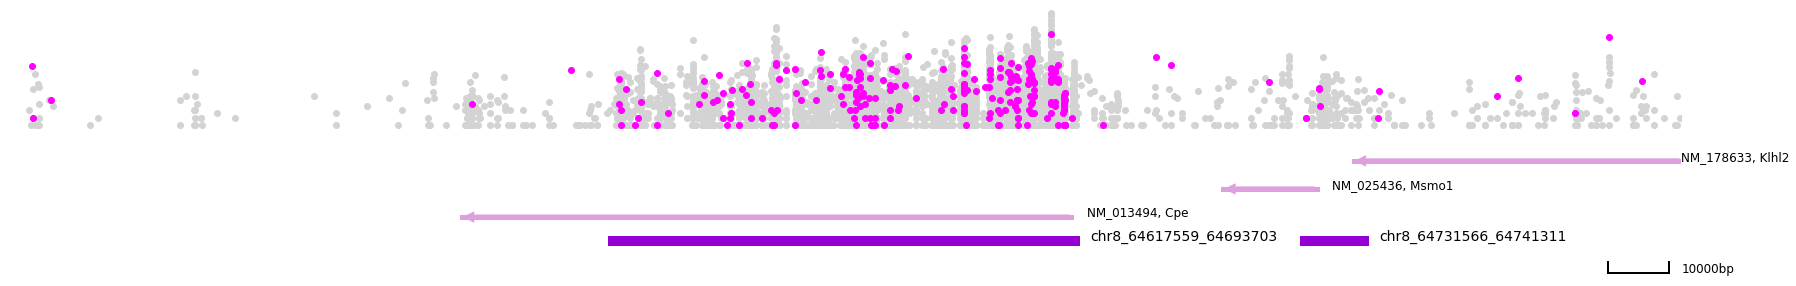

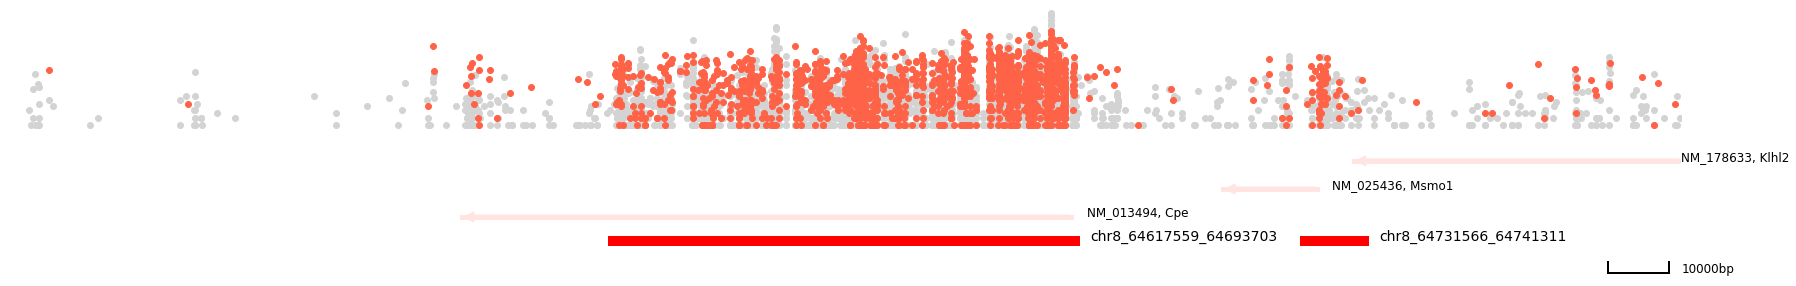

In [15]:
cc.pl.draw_area("chr8",64617559,64693703,100000, peak_data, SP1,"mm10",adata = adata_ccf, background = bg,
                name = "P10",key = "Index",htopkey = "sample", figsize = (30,5),peak_line = 1,color = "purple")
cc.pl.draw_area("chr8",64617559,64693703,100000, peak_data, SP1,"mm10",adata = adata_ccf, background = bg,
                name = "P28",key = "Index", htopkey = "sample", figsize = (30,5),peak_line = 1)

Save the file if needed.

In [16]:
adata_ccf.write("SP1_CCF.h5ad")